In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegressionCV
IMAGE_TO_DISPLAY=10

SIZE_BLOCK = 10000

In [2]:
# display image
def display(img):
    image_size = img.shape[0]
    image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)


In [3]:
# read training data from CSV file 
data = pd.read_csv('./dataset/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

images = data.iloc[:,1:].values
images = images.astype(np.float)

print('images({0[0]},{0[1]})'.format(images.shape))
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

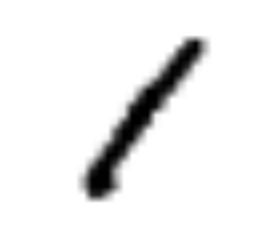

In [4]:
display(images[0])


In [5]:
# Scaling between 0 and 1
images = images[0:SIZE_BLOCK]
labels_flat = labels_flat[0:SIZE_BLOCK]
images = (images - np.min(images, 0)) / (np.max(images, 0) + 0.0001)  # 0-1 scaling
# Convert to binary images
images = images > 0.5
print('Input X shape', images.shape)


('Input X shape', (10000, 784))


1


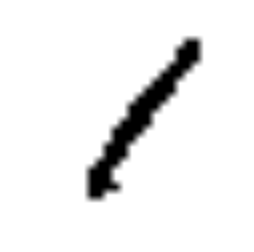

In [6]:
display(images[0])
print(labels_flat[0])


In [7]:
rbmWithSup = BernoulliRBM(n_components=200, learning_rate=0.01, batch_size=10, n_iter=40, verbose=True, random_state=None)
rbmNoSup = BernoulliRBM(n_components=200, learning_rate=0.01, batch_size=10, n_iter=40, verbose=True, random_state=None)


X_train, X_test, Y_train, Y_test = train_test_split( images, labels_flat, test_size=0.2, random_state=0)


In [8]:
inputForClassificationSuper = rbmWithSup.fit_transform(X_train,Y_train)
inputForClassificationNotSuper = rbmNoSup.fit_transform(X_train)



[BernoulliRBM] Iteration 1, pseudo-likelihood = -161.97, time = 22.50s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -133.30, time = 17.07s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -122.34, time = 17.41s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -119.47, time = 40.56s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -110.85, time = 41.30s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -107.36, time = 32.17s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -95.81, time = 17.07s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -99.37, time = 23.45s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -92.18, time = 25.08s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -91.46, time = 31.52s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -90.25, time = 25.22s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -87.61, time = 21.95s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -84.67, time = 15.22s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -84.77, time = 14.55s
[Bernoull

In [9]:
logisticWithSup = linear_model.LogisticRegression(C=10)
logisticNoSup = linear_model.LogisticRegression(C=10)
logisticWithSup = logisticWithSup.fit(inputForClassificationSuper,Y_train)
logisticNoSup = logisticNoSup.fit(inputForClassificationNotSuper,Y_train)

In [10]:
X_test_tranform_with_sup = rbmWithSup.transform(X_test)
X_test_tranform_No_sup = rbmNoSup.transform(X_test)


# X_test_tranform_with_sup = rbmWithSup.fit_transform(X_test)
# X_test_tranform_No_sup = rbmNoSup.fit_transform(X_test)


Y_predWithSup = logisticWithSup.predict(X_test_tranform_with_sup)
Y_predNoSup = logisticNoSup.predict(X_test_tranform_No_sup)




In [11]:

print ( 'With super in pre-training Score:  ')
print (metrics.classification_report(Y_test, Y_predWithSup))
print ( 'No super in pre-training Score:  ')
print((metrics.classification_report(Y_test, Y_predNoSup)))

With super in pre-training Score:  
             precision    recall  f1-score   support

          0       0.97      0.98      0.97       204
          1       0.96      0.98      0.97       221
          2       0.93      0.91      0.92       173
          3       0.90      0.90      0.90       218
          4       0.92      0.91      0.92       197
          5       0.90      0.87      0.89       183
          6       0.96      0.98      0.97       202
          7       0.97      0.96      0.96       223
          8       0.85      0.90      0.87       183
          9       0.92      0.89      0.91       196

avg / total       0.93      0.93      0.93      2000

No super in pre-training Score:  
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       204
          1       0.97      0.98      0.98       221
          2       0.90      0.92      0.91       173
          3       0.93      0.89      0.91       218
          4       0.93   

In [12]:
compWith =rbmWithSup.components_
compNo =rbmNoSup.components_

In [14]:
print(compWith.shape)
print(compNo.shape)

(200, 784)
(200, 784)


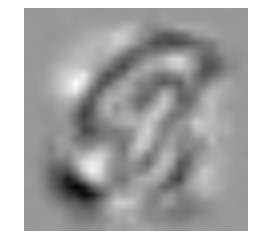

In [21]:
img = compWith[5]
one_image = img.reshape(28,28)

plt.axis('off')
plt.imshow(one_image, cmap=cm.binary)

In [22]:
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
    


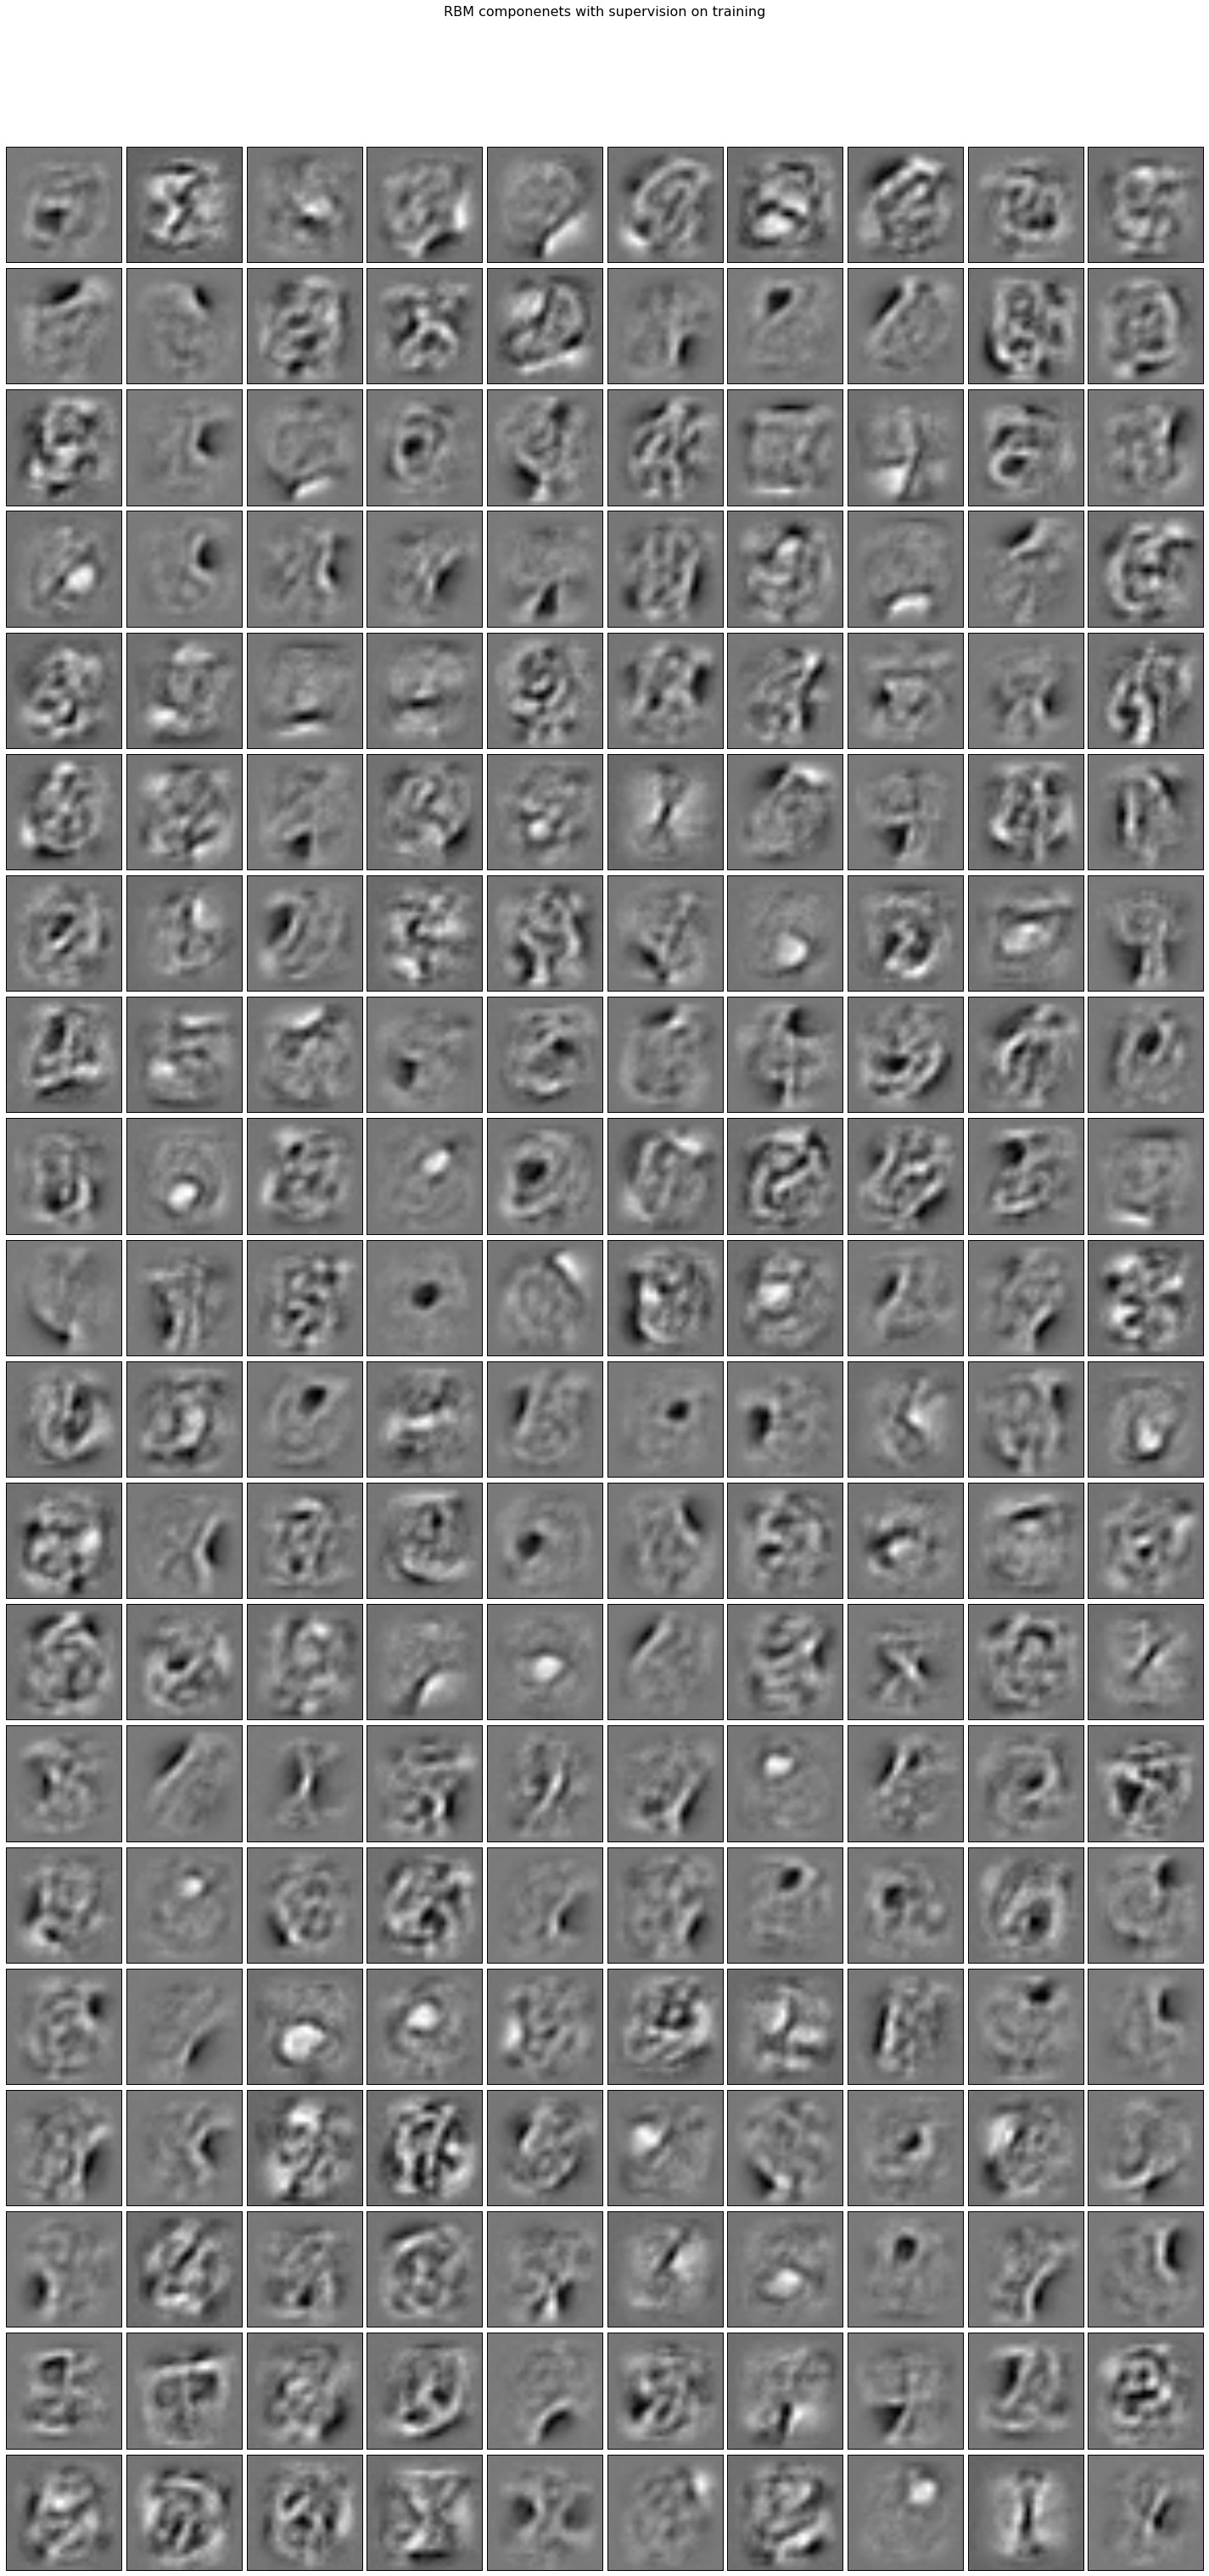

In [27]:
plot_gallery('RBM componenets with supervision on training', compWith, 10,20)

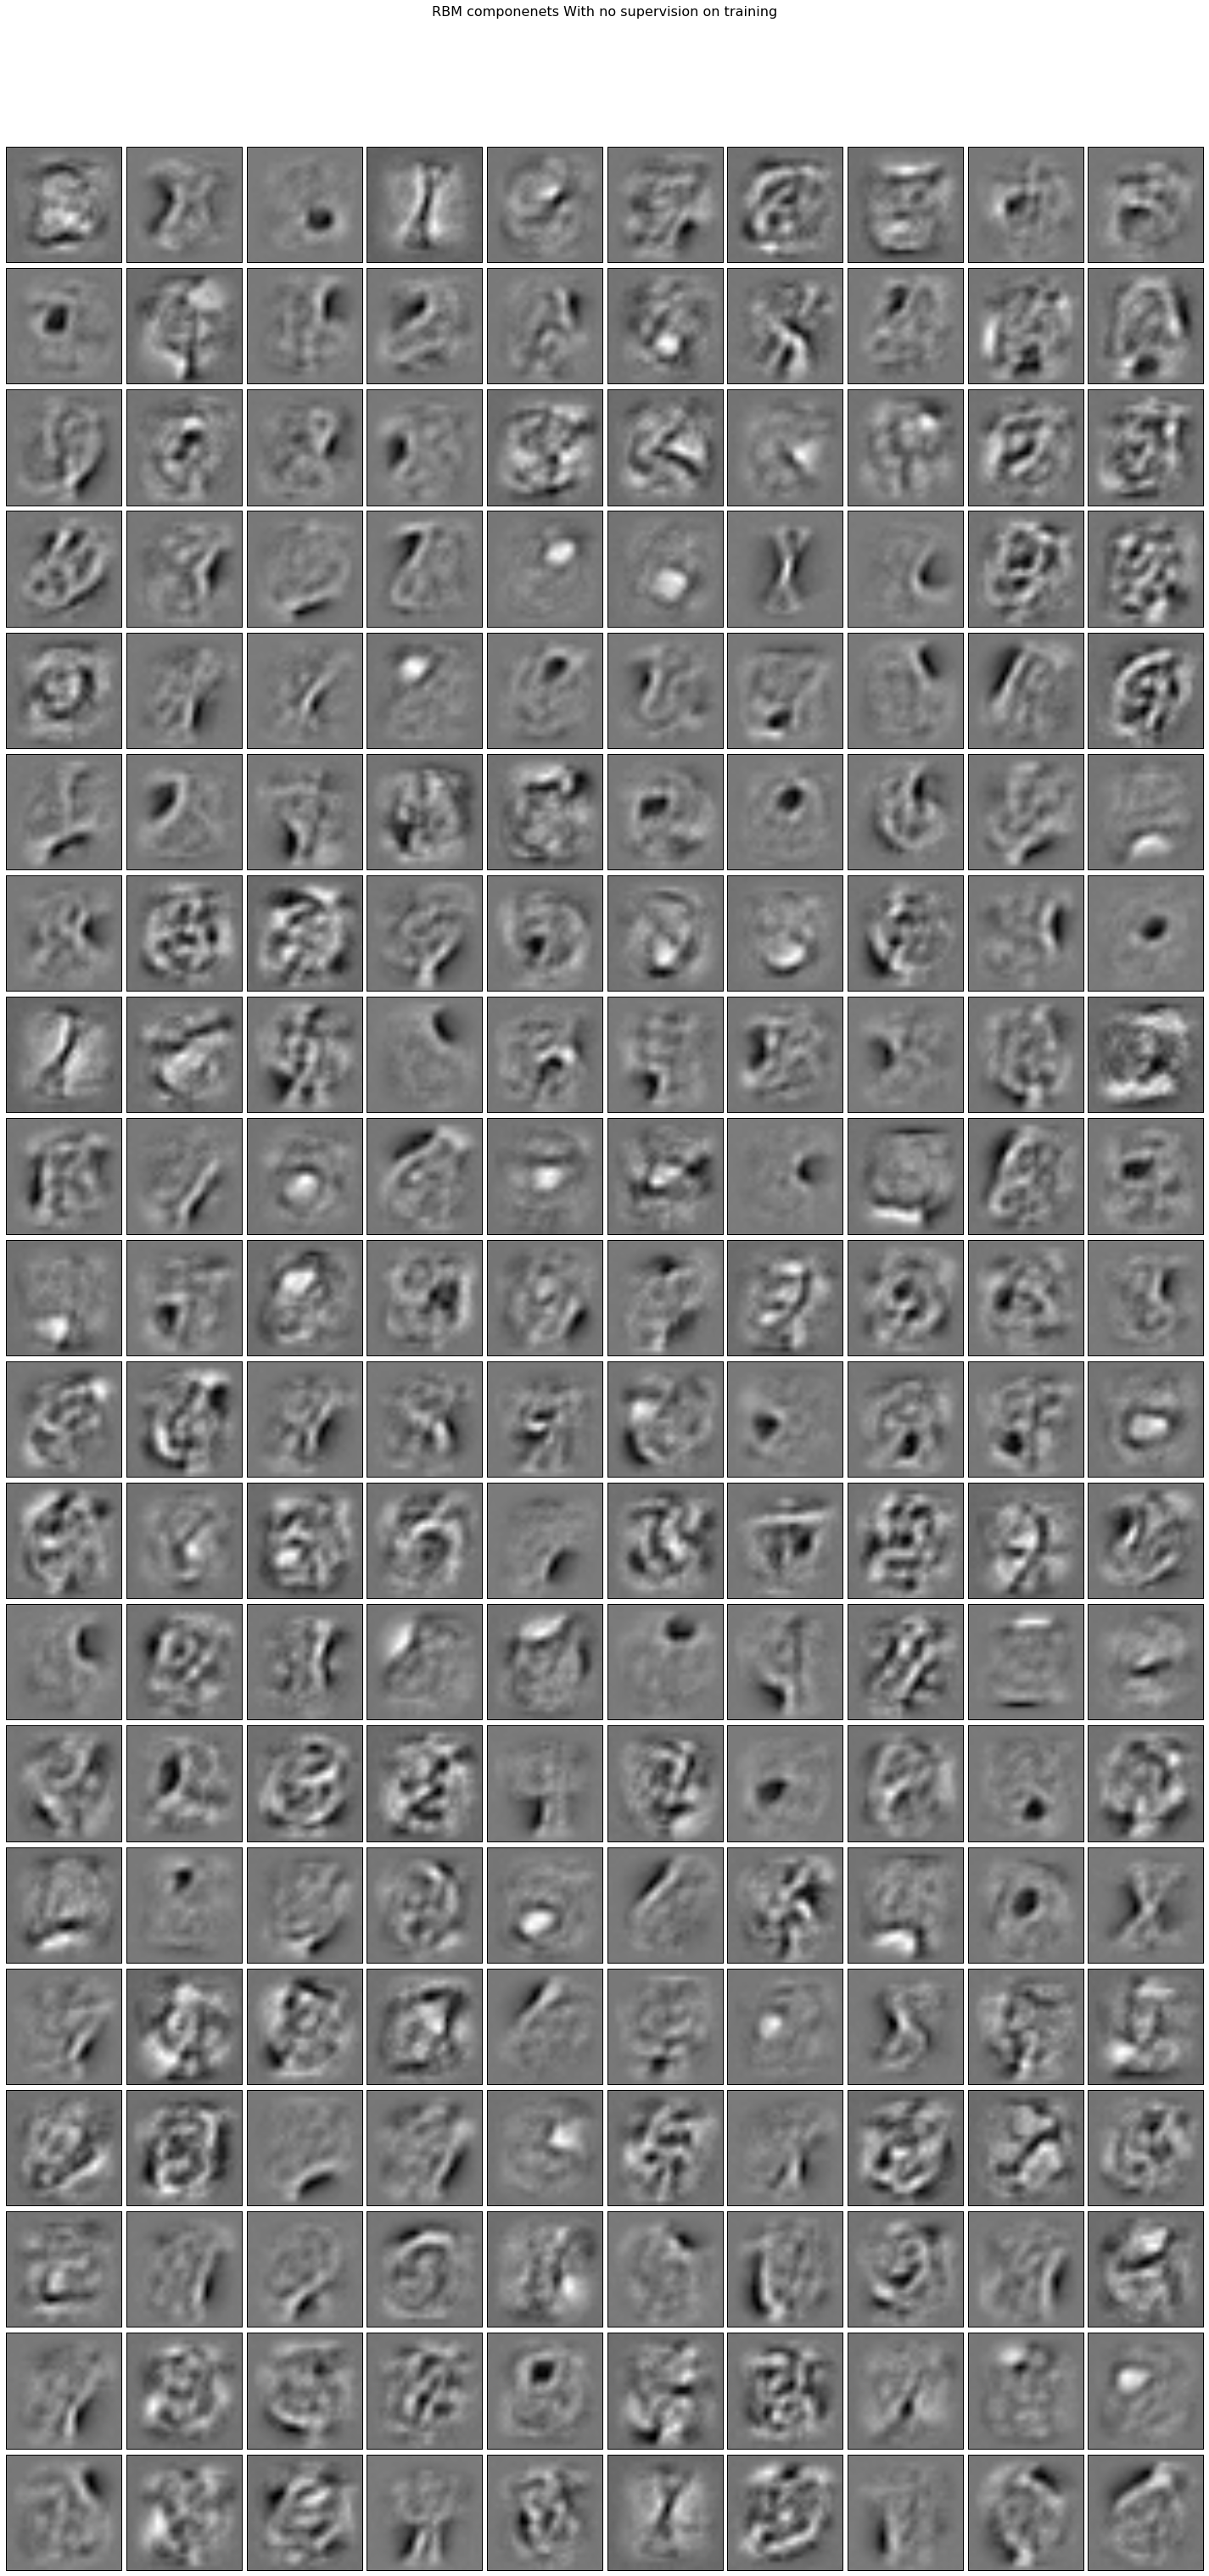

In [28]:
plot_gallery('RBM componenets With no supervision on training', compNo, 10,20)